In [1]:
# load densenet arch and make an eye detector (idea: with attention regions)

In [2]:
import os
import sys

sys.path.append('../')

import cv2
import json
import math
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import load_image
from augmentations import avg_aug

In [3]:
from tflow.DenseNet10.keras_fc_densenet import _create_fc_dense_net
from tflow.DenseNet10.keras_fc_densenet import _dense_block, _transition_down_block

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Input, BatchNormalization, Activation, Dropout, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

In [5]:
# make a better way to store all this in a config.json file to be readable as "experiment" counter # save a list of this json objects

img_input = Input((224, 224, 3))
bn_momentum = 0.9
concat_axis = -1
data_format = "channels_last"
dropout_rate = 0.2
weight_decay = 1e-4
transition_pooling = 'max'

# Initial convolution
with tf.name_scope("Initial"):
    x = Conv2D(
        48,
        (3, 3),
        kernel_initializer="he_normal",
        padding="same",
        use_bias=False,
        kernel_regularizer=l2(weight_decay),
        data_format=data_format,
    )(img_input)
    x = BatchNormalization(
        momentum=bn_momentum, axis=concat_axis, epsilon=1.1e-5
    )(x)
    x = Activation("relu")(x)

2022-07-29 14:26:08.840525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:26:08.867189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:26:08.867609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:26:08.868229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [6]:
# keeps track of the current number of feature maps
nb_filter = 42
growth_rate = 4
nb_dense_block = 4
nb_layers_per_block = 3
bottleneck_nb_layers = nb_layers_per_block
nb_layers = [nb_layers_per_block] * (2 * nb_dense_block + 1)

# collect skip connections on the downsampling path so that
# they can be concatenated with outputs on the upsampling path
skip_list = []

# Build the downsampling path by adding dense blocks and transition down blocks
for block_idx in range(nb_dense_block):
    x, nb_filter, _ = _dense_block(
        x,
        nb_layers[block_idx],
        nb_filter,
        growth_rate,
        bn_momentum=bn_momentum,
        dropout_rate=dropout_rate,
        data_format=data_format,
        block_prefix="DenseBlock_%i" % block_idx,
    )

    skip_list.append(x)
    x = _transition_down_block(
        x,
        nb_filter,
        weight_decay=weight_decay,
        bn_momentum=bn_momentum,
        transition_pooling=transition_pooling,
        data_format=data_format,
        block_prefix="TransitionDown_%i" % block_idx,
    )

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(32, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(4, activation='sigmoid')(x)

In [7]:
model = Model(inputs=img_input, outputs=x)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 48  192        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Generator funct

In [9]:
# TODO: implement data augmentation for object detection

datapath = {
    'images_path': "/home/choppy/TOC/thesis-msc-2022/data/images/aws/bonafide/via_marked",
    'via_file': "/home/choppy/TOC/thesis-msc-2022/data/images/aws/bonafide/via_marked/via_region_data.json"
}

In [10]:
with open(datapath.get('via_file')) as f:
    data = json.load(f)
    images_tensor = []
    coords_tensor = []
    
    for key in data.keys():
        impath = os.path.join(datapath.get('images_path'), data[key].get('filename'))
        # need to get image shape to properly format regions
        # image = Image.open(impath)
        # im_width, im_height = image.size
                     
        regions = data[key]['regions']
        
        if regions: # will be a empty list or list of regions
            shape_attributes = regions[0]['shape_attributes'] # take the first because is the unique region on the image
            # load marks
            region_name = shape_attributes.get('name') # will return "rect". Not used
            x = shape_attributes.get('x')
            y = shape_attributes.get('y')
            width = shape_attributes.get('width')
            height = shape_attributes.get('height')
            
            # make array with batch size and coords
            coords = np.array([x, y, x+width, y+height])
            
            # append data to tensors
            images_tensor.append(impath)
            coords_tensor.append(coords)

aug = avg_aug()
images_tensor = tf.cast(images_tensor, dtype=tf.string)
coords_tensor = tf.cast(coords_tensor, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((images_tensor, coords_tensor))

def _parse_function(impath, coords):
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    h_image = tf.shape(image_decoded)[0]
    w_image = tf.shape(image_decoded)[1]
    image = tf.image.resize(image_decoded, (224, 224))
    image = tf.cast(image, tf.uint8)
    # do augmentation here. Had a lot of problems figuring how to solve this part xd
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    coords = coords / [w_image, h_image, w_image, h_image] # image width, height
    return image, coords

dataset = dataset.map(_parse_function)
dataset = dataset.cache()
dataset = dataset.batch(5)

In [11]:
dataset, len(dataset)

(<BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>,
 27)

In [12]:
train_ds = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
val_ds = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

# Show first image from train set

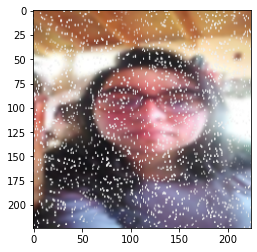

tf.Tensor([0.2897196  0.36052632 0.78504676 0.48421052], shape=(4,), dtype=float32)


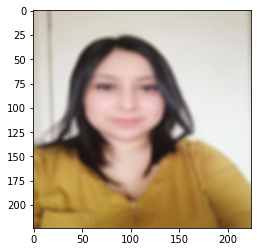

tf.Tensor([0.214      0.27306828 0.613      0.40810204], shape=(4,), dtype=float32)


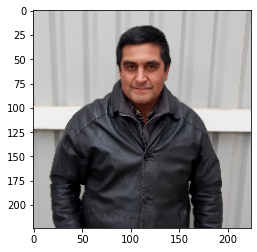

tf.Tensor([0.39833334 0.20666666 0.6        0.30833334], shape=(4,), dtype=float32)


/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thes

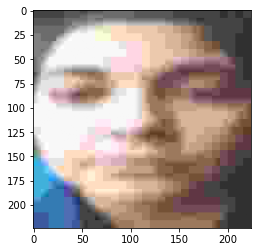

tf.Tensor([0.01401869 0.22105263 0.9766355  0.49736843], shape=(4,), dtype=float32)


/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


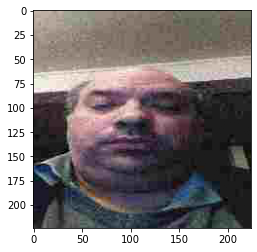

tf.Tensor([0.19626169 0.35263157 0.73364484 0.5026316 ], shape=(4,), dtype=float32)


2022-07-29 14:26:11.764326: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
for im, coords in dataset.take(5):
    plt.imshow(im[0])
    plt.show()
    print(coords[0])

# Train config

In [14]:
# ref: https://chowdera.com/2022/04/202204081842317781.html

def IoU(box1, box2):
    # check metric and order of operations
    # or, change the format of the dataset to be readable for the function

    # ①  To calculate iou
    #  Receive coordinate information of prediction frame 
    box1_xy = box1[..., 0:2]  #  The central coordinate of the prediction frame 
    box1_wh = box1[..., 2:4]  #  The width and height of the prediction box 
    box1_wh_half = box1_wh // 2  #  Half the width and height of the prediction frame 
    box1_min = box1_xy - box1_wh_half  #  Coordinates of the upper left corner of the prediction box 
    box1_max = box1_xy + box1_wh_half  #  Coordinates of the lower right corner of the prediction box 
    #  The area of the prediction box 
    box1_area = box1_wh[..., 0] * box1_wh[..., 1]

    #  Receive the coordinate information of the real frame 
    box2_xy = box2[..., 0:2]  #  The center coordinate of the real frame 
    box2_wh = box2[..., 2:4]  #  The width and height of the real frame 
    box2_wh_half = box2_wh // 2  #  Half the width and height 
    box2_min = box2_xy - box2_wh_half  #  The coordinates of the upper left corner of the real box 
    box2_max = box2_xy + box2_wh_half  #  The coordinates of the lower right corner of the real box 
    #  The area of the real box 
    box2_area = box2_wh[..., 0] * box2_wh[..., 1]

    #  Coordinates of the upper left and lower right corners of the intersection 
    intersect_min = tf.maximum(box1_min, box2_min)
    intersect_max = tf.minimum(box1_max, box2_max)
    #  The width and height of the intersection 
    intersect_wh = intersect_max - intersect_min
    #  The area of the intersection 
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    #  The area of the Union 
    union_area = box1_area + box2_area - intersect_area
    #  Calculation iou, The denominator plus a small number is 0
    iou = intersect_area / (union_area + tf.keras.backend.epsilon())

    # ②  Find the smallest closed rectangle containing two boxes 
    enclose_min = tf.minimum(box1_min, box2_min)  #  Left upper coordinate 
    enclose_max = tf.maximum(box1_max, box2_max)  #  Lower right coordinate 

    #  Calculate diagonal distance 
    enclose_distance = tf.reduce_sum(tf.square(enclose_max - enclose_min), axis=-1)

    #  Calculate the distance between the center points of two frames , The calculation method is the same as above 
    center_distance = tf.reduce_sum(tf.square(box1_xy - box2_xy), axis=-1)
    
    # ③  Consider the aspect ratio 
    # tf.math.atan2() return [-pi, pi] The angle between 
    v = 4 * tf.square(tf.math.atan2(box1_wh[..., 0], box1_wh[..., 1]) - tf.math.atan2(box2_wh[..., 0], box2_wh[..., 1])) / (math.pi * math.pi)
    alpha = v / (1.0 - iou + v)

    #  Calculation ciou
    ciou = iou - center_distance / enclose_distance - alpha * v

    return iou

def CIoU(box1, box2):
    # ①  To calculate iou
    #  Receive coordinate information of prediction frame 
    box1_xy = box1[..., 0:2]  #  The central coordinate of the prediction frame 
    box1_wh = box1[..., 2:4]  #  The width and height of the prediction box 
    box1_wh_half = box1_wh // 2  #  Half the width and height of the prediction frame 
    box1_min = box1_xy - box1_wh_half  #  Coordinates of the upper left corner of the prediction box 
    box1_max = box1_xy + box1_wh_half  #  Coordinates of the lower right corner of the prediction box 
    #  The area of the prediction box 
    box1_area = box1_wh[..., 0] * box1_wh[..., 1]

    #  Receive the coordinate information of the real frame 
    box2_xy = box2[..., 0:2]  #  The center coordinate of the real frame 
    box2_wh = box2[..., 2:4]  #  The width and height of the real frame 
    box2_wh_half = box2_wh // 2  #  Half the width and height 
    box2_min = box2_xy - box2_wh_half  #  The coordinates of the upper left corner of the real box 
    box2_max = box2_xy + box2_wh_half  #  The coordinates of the lower right corner of the real box 
    #  The area of the real box 
    box2_area = box2_wh[..., 0] * box2_wh[..., 1]

    #  Coordinates of the upper left and lower right corners of the intersection 
    intersect_min = tf.maximum(box1_min, box2_min)
    intersect_max = tf.minimum(box1_max, box2_max)
    #  The width and height of the intersection 
    intersect_wh = intersect_max - intersect_min
    #  The area of the intersection 
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    #  The area of the Union 
    union_area = box1_area + box2_area - intersect_area
    #  Calculation iou, The denominator plus a small number is 0
    iou = intersect_area / (union_area + tf.keras.backend.epsilon())

    # ②  Find the smallest closed rectangle containing two boxes 
    enclose_min = tf.minimum(box1_min, box2_min)  #  Left upper coordinate 
    enclose_max = tf.maximum(box1_max, box2_max)  #  Lower right coordinate 

    #  Calculate diagonal distance 
    enclose_distance = tf.reduce_sum(tf.square(enclose_max - enclose_min), axis=-1)

    #  Calculate the distance between the center points of two frames , The calculation method is the same as above 
    center_distance = tf.reduce_sum(tf.square(box1_xy - box2_xy), axis=-1)
    
    # ③  Consider the aspect ratio 
    # tf.math.atan2() return [-pi, pi] The angle between 
    v = 4 * tf.square(tf.math.atan2(box1_wh[..., 0], box1_wh[..., 1]) - tf.math.atan2(box2_wh[..., 0], box2_wh[..., 1])) / (math.pi * math.pi)
    alpha = v / (1.0 - iou + v)

    #  Calculation ciou
    ciou = iou - center_distance / enclose_distance - alpha * v

    return ciou

def iou_loss(y_true, y_pred):
    return 1-IoU(y_true, y_pred)

In [15]:
lr = 1e-4

# no converge
# opt = tf.keras.optimizers.Adadelta(
#     learning_rate=lr,
#     rho=0.95,
#     epsilon=1e-07,
#     name='AdadeltaOpt',
# )

# converge muy rapido
# opt = tf.keras.optimizers.RMSprop(
#     learning_rate=lr,
#     rho=0.9,
#     momentum=0.9,
#     epsilon=1e-07,
#     centered=False,
#     name='RMSpropOpt',
# )

# delicioso
opt = tf.keras.optimizers.SGD(
    learning_rate=lr,
    momentum=0.9,
    nesterov=True,
    name='SGDOpt',
)

model.compile(
    optimizer=opt,
    loss=tf.losses.MeanSquaredError(),
    # loss=tf.losses.MeanSquaredLogarithmicError(),
    # loss=iou_loss,
    metrics=['mae', 'mse', IoU, CIoU]
)

# Callbacks

In [16]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=20,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=1e-15,
    ),
    
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=10,
    )
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    max_queue_size=10,
    workers=10,
    use_multiprocessing=True,
    callbacks=callbacks,
)

Epoch 1/500


/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
2022-07-29 14:26:14.063047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-07-29 14:26:14.524466: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-29 14:26:14.525004: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child pr

 3/27 [==>...........................] - ETA: 1s - loss: 0.1552 - mae: 0.2468 - mse: 0.0882 - IoU: 0.1298 - CIoU: -0.8815 

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 4/27 [===>..........................] - ETA: 6s - loss: 0.1699 - mae: 0.2608 - mse: 0.1029 - IoU: 0.1221 - CIoU: -0.8913

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


 5/27 [====>.........................] - ETA: 5s - loss: 0.1662 - mae: 0.2534 - mse: 0.0992 - IoU: 0.1131 - CIoU: -0.9013

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 7/27 [======>.......................] - ETA: 5s - loss: 0.1661 - mae: 0.2543 - mse: 0.0991 - IoU: 0.0986 - CIoU: -0.9206

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


 9/27 [=========>....................] - ETA: 4s - loss: 0.1623 - mae: 0.2521 - mse: 0.0953 - IoU: 0.0889 - CIoU: -0.9270

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


10/27 [==========>...................] - ETA: 4s - loss: 0.1594 - mae: 0.2479 - mse: 0.0924 - IoU: 0.0860 - CIoU: -0.9286

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


11/27 [===========>..................] - ETA: 4s - loss: 0.1598 - mae: 0.2500 - mse: 0.0928 - IoU: 0.0911 - CIoU: -0.9230

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


12/27 [============>.................] - ETA: 4s - loss: 0.1551 - mae: 0.2422 - mse: 0.0881 - IoU: 0.0862 - CIoU: -0.9268

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


13/27 [=============>................] - ETA: 4s - loss: 0.1539 - mae: 0.2416 - mse: 0.0869 - IoU: 0.0838 - CIoU: -0.9296

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


14/27 [==============>...............] - ETA: 3s - loss: 0.1563 - mae: 0.2465 - mse: 0.0893 - IoU: 0.0924 - CIoU: -0.9216

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/en

16/27 [================>.............] - ETA: 3s - loss: 0.1576 - mae: 0.2482 - mse: 0.0906 - IoU: 0.0923 - CIoU: -0.9215

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


17/27 [=================>............] - ETA: 3s - loss: 0.1568 - mae: 0.2466 - mse: 0.0898 - IoU: 0.0907 - CIoU: -0.9229

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


18/27 [===================>..........] - ETA: 3s - loss: 0.1560 - mae: 0.2462 - mse: 0.0890 - IoU: 0.0947 - CIoU: -0.9184

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imagecorruptions/corruptions.py:188: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)


20/27 [=====================>........] - ETA: 2s - loss: 0.1583 - mae: 0.2493 - mse: 0.0913 - IoU: 0.1057 - CIoU: -0.9053

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


21/27 [======================>.......] - ETA: 2s - loss: 0.1574 - mae: 0.2464 - mse: 0.0904 - IoU: 0.1020 - CIoU: -0.9094

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


22/27 [=======================>......] - ETA: 1s - loss: 0.1582 - mae: 0.2482 - mse: 0.0912 - IoU: 0.1027 - CIoU: -0.9097

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


23/27 [========================>.....] - ETA: 1s - loss: 0.1573 - mae: 0.2470 - mse: 0.0903 - IoU: 0.0996 - CIoU: -0.9127

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


24/27 [=========================>....] - ETA: 1s - loss: 0.1582 - mae: 0.2482 - mse: 0.0912 - IoU: 0.0993 - CIoU: -0.9133

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)


25/27 [==========================>...] - ETA: 0s - loss: 0.1581 - mae: 0.2478 - mse: 0.0911 - IoU: 0.1002 - CIoU: -0.9125

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-20

26/27 [===========================>..] - ETA: 0s - loss: 0.1592 - mae: 0.2494 - mse: 0.0922 - IoU: 0.1075 - CIoU: -0.9062

/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:484: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=sigma, multichannel=True) * 255)
/home/choppy/TOC/.conda/envs/msc-thesis-2022/lib/python3.9/site-packages/imgaug/augmenters/imgcorruptlike.py:516: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gaussian(x / 255., sigma=sigma, multichannel=True),


27/27 [==============================] - 18s 443ms/step - loss: 0.1589 - mae: 0.2493 - mse: 0.0919 - IoU: 0.1078 - CIoU: -0.9055 - val_loss: 0.1214 - val_mae: 0.1876 - val_mse: 0.0544 - val_IoU: 0.0528 - val_CIoU: -0.9495 - lr: 1.0000e-04
Epoch 2/500
27/27 [==============================] - 2s 85ms/step - loss: 0.1647 - mae: 0.2514 - mse: 0.0977 - IoU: 0.1103 - CIoU: -0.9136 - val_loss: 0.1256 - val_mae: 0.1963 - val_mse: 0.0586 - val_IoU: 0.0547 - val_CIoU: -0.9495 - lr: 1.0000e-04
Epoch 3/500
27/27 [==============================] - 2s 85ms/step - loss: 0.1542 - mae: 0.2390 - mse: 0.0872 - IoU: 0.0771 - CIoU: -0.9378 - val_loss: 0.1268 - val_mae: 0.1977 - val_mse: 0.0598 - val_IoU: 0.0537 - val_CIoU: -0.9513 - lr: 1.0000e-04
Epoch 4/500
27/27 [==============================] - 2s 84ms/step - loss: 0.1500 - mae: 0.2353 - mse: 0.0830 - IoU: 0.0873 - CIoU: -0.9254 - val_loss: 0.1256 - val_mae: 0.1958 - val_mse: 0.0586 - val_IoU: 0.0529 - val_CIoU: -0.9518 - lr: 1.0000e-04
Epoch 5/500
27

In [ ]:
# TODO: evaluate model with test data

In [1]:
model.evaluate(val_ds)

NameError: name 'model' is not defined

In [ ]:
model.save(filepath='eye_detector_model.hdf5')

In [ ]:
new_model = tf.keras.models.load_model(filepath='eye_detector_model.hdf5')

In [ ]:
new_model.summary()

In [ ]:
# plot history with losses and metrics in two figures

In [ ]:
history.history.keys()

In [ ]:
lr = history.history.pop('lr', None) # not used

In [ ]:
hist = history.history

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

for key in hist.keys():
    if 'val_' not in key:
        axes[0].plot(hist[key], label=key)
    else:
        axes[1].plot(hist[key], label=key)

axes[0].legend()
axes[1].legend()

plt.ylim([-0.1, 1])
plt.show()